In [2]:
import requests
import numpy as np
from bs4 import BeautifulSoup as bs
import pandas as pd
import re
import math
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from phik.report import plot_correlation_matrix
import phik
from phik import resources, report
from sklearn.model_selection import train_test_split
from conf.conf import logging, settings

import warnings
warnings.filterwarnings("ignore")

0.VARIABLES


In [2]:
TARGET = 'sales'
CAT_URL = 'https://www.wildberries.ru/catalog/obuv/muzhskaya','dataobuv.csv'
SAVE_PATH = 'curs/dataobuv.csv'

1.PARSER

In [3]:
def get_catalogs_wb(CATALOGUE_PATH= settings.PATH.CATALOGUE_PATH)->list:
    url = 'https://www.wildberries.ru/webapi/menu/main-menu-ru-ru.json'
    headers = {'Accept': "*/*", 'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    response = requests.get(url, headers=headers)
    data = response.json()
    with open(CATALOGUE_PATH, 'w', encoding='UTF-8') as file:
        json.dump(data, file, indent=2, ensure_ascii=False)
    data_list = []
    for d in data:
        try:
            for child in d['childs']:
                try:
                    category_name = child['name']
                    category_url = child['url']
                    shard = child['shard']
                    query = child['query']
                    data_list.append({
                        'category_name': category_name,
                        'category_url': category_url,
                        'shard': shard,
                        'query': query})
                except:
                    continue
                try:
                    for sub_child in child['childs']:
                        category_name = sub_child['name']
                        category_url = sub_child['url']
                        shard = sub_child['shard']
                        query = sub_child['query']
                        data_list.append({
                            'category_name': category_name,
                            'category_url': category_url,
                            'shard': shard,
                            'query': query})
                except:
                    continue
        except:
            continue
    return data_list


def search_category_in_catalog(url, catalog_list):
    """
    
    """
    try:
        for catalog in catalog_list:
            if catalog['category_url'] == url.split('https://www.wildberries.ru')[-1]:
                print(f'найдено совпадение: {catalog["category_name"]}')
                name_category = catalog['category_name']
                shard = catalog['shard']
                query = catalog['query']
                return name_category, shard, query
            else:
                # print('нет совпадения')
                pass
    except:
        print('Данный раздел не найден!')


def get_data_from_json(json_file):
    """
    Creates Product Data Frame from json file
    """
    data_list = []
    logging.info('df is being prepared')
    for data in json_file['data']['products']:
        try:
            price = int(data["priceU"] / 100)
        except:
            price = 0
        data_list.append({
            'name': data['name'],
            'id': data['id'],
            'discount': data['sale'],
            'price': price,
            'dicsounted Price': int(data["salePriceU"] / 100),
            'barnd': data['brand']
            
        })
    return data_list


def get_content(shard, query, low_price=None, top_price=None):
    'Scrapse product data'
    logging.info('parsing started')
    headers = {'Accept': "*/*", 'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    data_list = []
    for page in tqdm(range(1, 101)):
        url = f'https://catalog.wb.ru/catalog/{shard}/catalog?appType=1&curr=rub&dest=-1075831,-77677,-398551,12358499' \
              f'&locale=ru&page={page}&priceU={low_price * 100};{top_price * 100}' \
              f'&reg=0&regions=64,83,4,38,80,33,70,82,86,30,69,1,48,22,66,31,40&sort=popular&spp=0&{query}'
        r = requests.get(url, headers=headers)
        data = r.json()
        if len(get_data_from_json(data)) > 0:
            data_list.extend(get_data_from_json(data))
        else:
            break
    logging.info('parsing started')
    return data_list


def save_excel(data, filename):
    """сохранение результата в excel файл"""
    df = pd.DataFrame(data)
    writer = pd.ExcelWriter(f'{filename}.xlsx')
    df.to_excel(writer, 'data')
    writer.save()
    print(f'Все сохранено в {filename}.xlsx')


def parser(url, low_price, top_price):
    # получаем список каталогов
    catalog_list = get_catalogs_wb()
    try:
        # поиск введенной категории в общем каталоге
        name_category, shard, query = search_category_in_catalog(url=url, catalog_list=catalog_list)
        # сбор данных в найденном каталоге
        data_list = get_content(shard=shard, query=query, low_price=low_price, top_price=top_price)
        # сохранение найденных данных
        save_excel(data_list, f'{name_category}_from_{low_price}_to_{top_price}')
        
        return data_list
    
    except TypeError:
        print('Ошибка! Возможно не верно указан раздел. Удалите все доп фильтры с ссылки')
    except PermissionError:
        print('Ошибка! Вы забыли закрыть созданный ранее excel файл. Закройте и повторите попытку')
        
        

In [4]:
dl = get_catalogs_wb()

In [7]:
dl = pd.DataFrame(dl)

In [8]:
dl

,category_name,category_url,shard,query
0,Блузки и рубашки,/catalog/zhenshchinam/odezhda/bluzki-i-rubashki,bl_shirts,cat=8126
1,Брюки,/catalog/zhenshchinam/odezhda/bryuki-i-shorty,pants,cat=8127
2,Верхняя одежда,/catalog/zhenshchinam/odezhda/verhnyaya-odezhda,outwear1,cat=63010
3,"Джемперы, водолазки и кардиганы",/catalog/zhenshchinam/odezhda/dzhempery-i-kard...,jumpers_cardigans,cat=8130
4,Джинсы,/catalog/zhenshchinam/odezhda/dzhinsy-dzhegginsy,jeanst1,cat=8131
...,...,...,...,...
1556,Сестрица,/catalog/vkusy-rossii/sestritsa,product,subject=3109&supplier=61633
1557,АВ1918,/catalog/vkusy-rossii/ab1918,product,subject=3109&supplier=61899
1558,6 КЛЁНОВ,/catalog/vkusy-rossii/6-klenov,product,subject=3109&supplier=74801
1559,Шоко Руа,/catalog/vkusy-rossii/shoko-rua,product,subject=3109&supplier=56946


In [6]:
id = 143330204
r= requests.get('https://basket-10.wb.ru/vol1433/part143330/143330204/info/ru/card.json')
r = r.json()
opt = pd.json_normalize(r['options'])
opt = opt.set_index('name')
opt= pd.DataFrame(opt.T)
opt['id'] = int(id)
opt['Описание'] = (r['description'])

In [7]:
opt

name,Материал седла,Ход вилки (мм),Вес без упаковки (кг),Размер рамы макс. (дюйм),Пол велосипеда,Страна производства,Велосипедный модельный год,Стиль катания,Возрастная группа,Тип велосипеда,...,Амортизация,Тип тормозов велосипеда,Тип рамы велосипеда,Размер рамы мин. (дюйм),Количество звезд в кассете,Длина упаковки,Высота упаковки,Ширина упаковки,id,Описание
value,искусственная кожа,120 мм,10.7 кг,20.5 дюйм,унисекс; мужской; детский,Китай,2023,фристайл; универсальный; классический,для всех возрастов,BMX,...,нет,V-brake,алюминиевая,20.5 дюйм,1,21 см,68 см,110 см,143330204,BMX от SKILL BIKE — велосипед для экстремально...


In [12]:
def get_features(id_list):
    '''
    Gets features for the products scrapped before
    '''
    z = pd.DataFrame()
    
    for id in tqdm(id_list):
        try:
            try:
                shard =  math.floor(id/14000000)
                str_id  = str(id)
                vol = str_id[:-5]
                part = str_id[:-3]
                if shard <10:
                    link = f'https://basket-0{shard}.wb.ru/vol{vol}/part{part}/{str_id}/info/ru/card.json'
                else:
                    link = f'https://basket-{shard}.wb.ru/vol{vol}/part{part}/{str_id}/info/ru/card.json'
                r = requests.get(link)
                r = r.json()
                opt = pd.json_normalize(r['options'])
                opt = opt.set_index('name')
                opt= pd.DataFrame(opt.T)
                opt['id'] = int(id)
                opt['Описание'] = (r['description'])
                z = pd.concat([z,opt])
            except:
                shard =  round(id/14000000)
                str_id  = str(id)
                vol = str_id[:-5]
                part = str_id[:-3]
                if shard <10:
                    link = f'https://basket-0{shard}.wb.ru/vol{vol}/part{part}/{str_id}/info/ru/card.json'
                else:
                    link = f'https://basket-{shard}.wb.ru/vol{vol}/part{part}/{str_id}/info/ru/card.json'
                r = r.json()
                opt = pd.json_normalize(r['options'])
                opt = opt.set_index('name')
                opt= pd.DataFrame(opt.T)
                opt['id'] = int(id)
                opt['Описание'] = (r['description'])
                z = pd.concat([z,opt])
        except:
            z = z
    return z

In [13]:
def data_cat_pipeline(url,path):
    cat_data = pd.DataFrame(parser(url,0,1000000000))
    id_list = cat_data['id'].values
    product_data = get_features(id_list)
    data = product_data.merge(cat_data, on='id')
    data.set_index('id')
    data.to_csv(path)
    
    return data

In [14]:
df = data_cat_pipeline('https://www.wildberries.ru/catalog/dlya-doma/predmety-interera/dekorativnye-nakleyki','dataobuv.csv')

найдено совпадение: Наклейки и декор


100%|█████████████████████████████████████████| 100/100 [00:12<00:00,  8.27it/s]


Все сохранено в Наклейки и декор_from_0_to_1000000000.xlsx


 18%|██████▉                               | 1818/10000 [01:02<04:06, 33.19it/s]

 19%|███████▏                              | 1901/10000 [01:04<03:37, 37.29it/s]

In [10]:
z = get_features(id_list)

100%|██████████| 6510/6510 [40:10<00:00,  2.70it/s]   


In [22]:
df = z.merge(x, on='id')

In [12]:
df

,Страна производства,ТНВЭД,Материал стельки,Особенности модели,Материал подошвы обуви,Длина упаковки,Высота упаковки,Ширина упаковки,id,Описание,...,Наименование,Скидка,Цена,Цена со скидкой,Бренд,id бренда,feedbacks,rating,sale,Ссылка
0,Вьетнам,6403993800,EVA,Унисекс - для мужчин и для женщин,croslite,20 см,10 см,12 см,62518844,Сабо Bayaband Clog,...,Сабо Bayaband Clog,57,6499,2794,CROCS,246,22308,4,57,https://www.wildberries.ru/catalog/62518844/de...
1,Вьетнам,6403991100,NaN,Унисекс - для мужчин и для женщин,croslite,20 см,10 см,12 см,62520256,Стиль Crocband отличает высокая подошва обтека...,...,Шлепанцы Bayaband Slide,38,4699,2913,CROCS,246,5189,5,38,https://www.wildberries.ru/catalog/62520256/de...
2,Китай,6401990000,текстиль,светящиеся кроссовки женские подростковые,ТПР,33 см,12 см,22 см,143386618,•\tСохраняй комфорт в кроссовках Nike Air Forc...,...,Кроссовки NIKE,68,14000,4480,обувь,63048,1360,4,68,https://www.wildberries.ru/catalog/143386618/d...
3,Вьетнам,6401990000,текстиль,Nike SB Dunk low,термоэластопласт,35 см,12 см,21 см,141217830,ОБРАЩАЕМ ВАШЕ ВНИМАНИЕ-КРОССОВКИ МАЛОМЕРЯТ НА ...,...,Кроссовки SB Dunk Low Purple Pigeon,54,9600,4416,Nike,671,380,5,54,https://www.wildberries.ru/catalog/141217830/d...
4,Китай,6405909000,NaN,"Спецобувь мужская на весну, осень, лето, демис...","ПУ (PU, Полиуретан)",32 см,11 см,20 см,111097058,"Сандалии мужские для работы ""Аскет"" подойдут д...",...,Сандалии рaбочие Аскет пoдошва ПУ,45,2775,1526,МИСТРАЛЬ.,74800,333,5,45,https://www.wildberries.ru/catalog/111097058/d...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5314,Индия,6405100009,текстиль,Анатомическая модель,полиуретан,36 см,12 см,21 см,62287271,Мужские кеды из натуральной кожи ECCO STREET L...,...,Кеды мужские натуральная кожа,0,11990,11990,ECCO,291,148,4,0,https://www.wildberries.ru/catalog/62287271/de...
5315,NaN,6401990000,NaN,NaN,NaN,30 см,15 см,25 см,143032186,Получите максимальную отдачу от каждого шага с...,...,Кроссовки Levitate 5,28,16299,11735,Brooks,3871,4,5,28,https://www.wildberries.ru/catalog/143032186/d...
5316,Вьетнам,6402190000,текстиль,дышащий материал,ТПР,32 см,12 см,20 см,160948862,Беговые кроссовки – это идеальное решение для ...,...,Кроссовки спортивные,38,9999,6199,ASICS,61,238,5,38,https://www.wildberries.ru/catalog/160948862/d...
5317,NaN,6403999600,текстиль,дышащий материал,резина,30 см,15 см,20 см,145998304,"ОБРАЩАЕМ ВАШЕ ВНИМЕНИЕ, эти КРОССОВКИ МАЛОМЕРЯ...",...,Кроссовки,68,13500,4320,Sigma,8673,12,5,68,https://www.wildberries.ru/catalog/145998304/d...


In [11]:
df.set_index('id')
df.to_csv('dataobuv.csv')

2.EDA

In [23]:
df2 = pd.read_csv('catalogue/Наклейки и декор.csv')
df2.shape

(4489, 40)

In [24]:
df2


,id,Страна производства,Материал изделия,Вес с упаковкой (кг),Вес товара с упаковкой (г),Длина упаковки,Высота упаковки,Ширина упаковки,Описание,Повод,...,Материал подставки,SKU,Диаметр,Коллекция,Тип искусственной еды,name,discount,price,dicsounted Price,barnd
0,149088302,Россия,мрамор; щебень,20.3 кг,20300 г,45 см,12 см,35 см,Мраморная крошка белая – это один из самых поп...,NaN,...,NaN,NaN,NaN,NaN,NaN,Мраморная крошка 10-20 мм 20 кг,25,998,748,MV&DOM
1,81331172,Россия,мраморная крошка 10-20мм; Мраморная крошка бел...,20.1 кг,20100 г,38 см,25 см,26 см,"Мраморная крошка белая, ВЫСОКОЕ КАЧЕСТВО, не ж...",NaN,...,NaN,NaN,NaN,NaN,NaN,мраморная крошка белая 10-20 мм,46,1400,756,МТА
2,114531175,Китай,ПВХ,NaN,27 г,1 см,33 см,23 см,Наклейки бабочки 3d (3д) самоклеящиеся декорат...,новоселье; день рождения; Выпускной,...,NaN,NaN,NaN,NaN,NaN,Наклейки на стену для декора дома интерьерные ...,40,422,253,0’stickers
3,65273105,Китай,ПВХ,NaN,27 г,1 см,33 см,23 см,Наклейки бабочки 3d (3д) самоклеящиеся декорат...,новоселье; день рождения; Выпускной,...,NaN,NaN,NaN,NaN,NaN,Наклейки на стену для декора дома интерьерные ...,40,352,211,0’stickers
4,14095660,Россия,наклейка ПВХ,NaN,360 г,7 см,39 см,7 см,Интерьерная декоративная наклейка на дверь шка...,8 Марта Новый год 14 февраля; 23 февраля; день...,...,NaN,NaN,NaN,NaN,NaN,Наклейка интерьерная на стену дверь шкаф обои ...,71,1620,469,MISHEBU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4484,109015588,Россия,ХДФ (дерево),NaN,2000 г,2 см,75 см,33 см,"Панно ""ВИТРАЖ"" .Материал ХДФ 3 мм.В качестве к...",новоселье; Рождение дочери; Новый год 2022,...,NaN,NaN,NaN,NaN,NaN,Декорация настенная,72,1780,498,ДРЕВКОМ
4485,163004792,Китай,акрил,NaN,NaN,12 см,5 см,5 см,Надпись Happy Birthday из толстого акрила (тол...,NaN,...,NaN,NaN,NaN,NaN,NaN,"Топпер ""Happy Birthday"", из акрила",30,704,492,BRIONDA
4486,163542059,Китай,акрил,NaN,NaN,12 см,5 см,5 см,Надпись Happy Birthday из толстого акрила (тол...,NaN,...,NaN,NaN,NaN,NaN,NaN,"Топпер ""Happy Birthday"", из акрила",30,704,492,BRIONDA
4487,163542080,Китай,акрил,NaN,NaN,12 см,5 см,5 см,Надпись Happy Birthday из толстого акрила (тол...,NaN,...,NaN,NaN,NaN,NaN,NaN,"Топпер ""Happy Birthday"", из акрила",30,704,492,BRIONDA


In [25]:
def get_clean_data(df:pd.DataFrame):
    for column in df.columns:
        if df[column].isnull().sum()/len(df) >= 0.14:
            df = df.drop(column,axis=1)
    return df
    

In [26]:
df_filtered = get_clean_data(df2)

In [27]:
df_filtered 


,id,Страна производства,Материал изделия,Длина упаковки,Высота упаковки,Ширина упаковки,Описание,name,discount,price,dicsounted Price,barnd
0,149088302,Россия,мрамор; щебень,45 см,12 см,35 см,Мраморная крошка белая – это один из самых поп...,Мраморная крошка 10-20 мм 20 кг,25,998,748,MV&DOM
1,81331172,Россия,мраморная крошка 10-20мм; Мраморная крошка бел...,38 см,25 см,26 см,"Мраморная крошка белая, ВЫСОКОЕ КАЧЕСТВО, не ж...",мраморная крошка белая 10-20 мм,46,1400,756,МТА
2,114531175,Китай,ПВХ,1 см,33 см,23 см,Наклейки бабочки 3d (3д) самоклеящиеся декорат...,Наклейки на стену для декора дома интерьерные ...,40,422,253,0’stickers
3,65273105,Китай,ПВХ,1 см,33 см,23 см,Наклейки бабочки 3d (3д) самоклеящиеся декорат...,Наклейки на стену для декора дома интерьерные ...,40,352,211,0’stickers
4,14095660,Россия,наклейка ПВХ,7 см,39 см,7 см,Интерьерная декоративная наклейка на дверь шка...,Наклейка интерьерная на стену дверь шкаф обои ...,71,1620,469,MISHEBU
...,...,...,...,...,...,...,...,...,...,...,...,...
4484,109015588,Россия,ХДФ (дерево),2 см,75 см,33 см,"Панно ""ВИТРАЖ"" .Материал ХДФ 3 мм.В качестве к...",Декорация настенная,72,1780,498,ДРЕВКОМ
4485,163004792,Китай,акрил,12 см,5 см,5 см,Надпись Happy Birthday из толстого акрила (тол...,"Топпер ""Happy Birthday"", из акрила",30,704,492,BRIONDA
4486,163542059,Китай,акрил,12 см,5 см,5 см,Надпись Happy Birthday из толстого акрила (тол...,"Топпер ""Happy Birthday"", из акрила",30,704,492,BRIONDA
4487,163542080,Китай,акрил,12 см,5 см,5 см,Надпись Happy Birthday из толстого акрила (тол...,"Топпер ""Happy Birthday"", из акрила",30,704,492,BRIONDA


In [16]:
for column in df_filtered.columns:
    if df_filtered[column].isnull().sum()/len(df) >= 0.14:
        df_filtered = df_filtered.drop(column,axis=1)

In [12]:
def get_column_cat(df):
    for column in df:
        print(column)

In [14]:
get_column_cat(df_filtered)

id
Страна производства
Материал изделия
Длина упаковки
Высота упаковки
Ширина упаковки
Описание
name
discount
price
dicsounted Price
barnd


In [11]:
df_filtered.columns

Index(['id', 'Страна производства', 'Материал изделия', 'Длина упаковки',
       'Высота упаковки', 'Ширина упаковки', 'Описание', 'name', 'discount',
       'price', 'dicsounted Price', 'barnd'],
      dtype='object')

In [15]:
def get_column_cat(df):
    CATEGORICAL_COLUMNS = []
    NUMERIC_COLUMNS = []
    TEXT_COLUMNS = []
    for column in df:
        logging.info(f'is {column} numeric,categorical,text or index column?')
        col_input = input()
        if col_input == 'numeric':
            NUMERIC_COLUMNS.append(column)
        elif col_input == 'categorical':
            CATEGORICAL_COLUMNS.append(column)
        elif col_input == 'text':
            TEXT_COLUMNS.append(column)
    return NUMERIC_COLUMNS,CATEGORICAL_COLUMNS,TEXT_COLUMNS

In [16]:
NUMERIC_COLUMNS,CATEGORICAL_COLUMNS,TEXT_COLUMNS = get_column_cat(df_filtered)

INFO:root:is id numeric,categorical,text or index column?
INFO:root:is Страна производства numeric,categorical,text or index column?
INFO:root:is Материал изделия numeric,categorical,text or index column?
INFO:root:is Длина упаковки numeric,categorical,text or index column?
INFO:root:is Высота упаковки numeric,categorical,text or index column?
INFO:root:is Ширина упаковки numeric,categorical,text or index column?
INFO:root:is Описание numeric,categorical,text or index column?
INFO:root:is name numeric,categorical,text or index column?
INFO:root:is discount numeric,categorical,text or index column?
INFO:root:is price numeric,categorical,text or index column?
INFO:root:is dicsounted Price numeric,categorical,text or index column?
INFO:root:is barnd numeric,categorical,text or index column?


In [17]:
NUMERIC_COLUMNS

['Длина упаковки',
 'Высота упаковки',
 'Ширина упаковки',
 'discount',
 'price',
 'dicsounted Price']

In [28]:
df_filtered

,id,Страна производства,Материал изделия,Длина упаковки,Высота упаковки,Ширина упаковки,Описание,name,discount,price,dicsounted Price,barnd
0,149088302,Россия,мрамор; щебень,45 см,12 см,35 см,Мраморная крошка белая – это один из самых поп...,Мраморная крошка 10-20 мм 20 кг,25,998,748,MV&DOM
1,81331172,Россия,мраморная крошка 10-20мм; Мраморная крошка бел...,38 см,25 см,26 см,"Мраморная крошка белая, ВЫСОКОЕ КАЧЕСТВО, не ж...",мраморная крошка белая 10-20 мм,46,1400,756,МТА
2,114531175,Китай,ПВХ,1 см,33 см,23 см,Наклейки бабочки 3d (3д) самоклеящиеся декорат...,Наклейки на стену для декора дома интерьерные ...,40,422,253,0’stickers
3,65273105,Китай,ПВХ,1 см,33 см,23 см,Наклейки бабочки 3d (3д) самоклеящиеся декорат...,Наклейки на стену для декора дома интерьерные ...,40,352,211,0’stickers
4,14095660,Россия,наклейка ПВХ,7 см,39 см,7 см,Интерьерная декоративная наклейка на дверь шка...,Наклейка интерьерная на стену дверь шкаф обои ...,71,1620,469,MISHEBU
...,...,...,...,...,...,...,...,...,...,...,...,...
4484,109015588,Россия,ХДФ (дерево),2 см,75 см,33 см,"Панно ""ВИТРАЖ"" .Материал ХДФ 3 мм.В качестве к...",Декорация настенная,72,1780,498,ДРЕВКОМ
4485,163004792,Китай,акрил,12 см,5 см,5 см,Надпись Happy Birthday из толстого акрила (тол...,"Топпер ""Happy Birthday"", из акрила",30,704,492,BRIONDA
4486,163542059,Китай,акрил,12 см,5 см,5 см,Надпись Happy Birthday из толстого акрила (тол...,"Топпер ""Happy Birthday"", из акрила",30,704,492,BRIONDA
4487,163542080,Китай,акрил,12 см,5 см,5 см,Надпись Happy Birthday из толстого акрила (тол...,"Топпер ""Happy Birthday"", из акрила",30,704,492,BRIONDA


In [29]:
def preprocess_num_col(NUMERIC_COLUMNS,df):
    for column in NUMERIC_COLUMNS:
        df[column] = df[column].apply(lambda value: re.sub('\D', '', str(value)))
        df[column] = df[column].replace('',0)
        df[column] = df[column].apply(lambda value: int(value))
    return df

In [30]:
df_filtered = preprocess_num_col(NUMERIC_COLUMNS,df_filtered)

In [31]:
df_filtered

,id,Страна производства,Материал изделия,Длина упаковки,Высота упаковки,Ширина упаковки,Описание,name,discount,price,dicsounted Price,barnd
0,149088302,Россия,мрамор; щебень,45,12,35,Мраморная крошка белая – это один из самых поп...,Мраморная крошка 10-20 мм 20 кг,25,998,748,MV&DOM
1,81331172,Россия,мраморная крошка 10-20мм; Мраморная крошка бел...,38,25,26,"Мраморная крошка белая, ВЫСОКОЕ КАЧЕСТВО, не ж...",мраморная крошка белая 10-20 мм,46,1400,756,МТА
2,114531175,Китай,ПВХ,1,33,23,Наклейки бабочки 3d (3д) самоклеящиеся декорат...,Наклейки на стену для декора дома интерьерные ...,40,422,253,0’stickers
3,65273105,Китай,ПВХ,1,33,23,Наклейки бабочки 3d (3д) самоклеящиеся декорат...,Наклейки на стену для декора дома интерьерные ...,40,352,211,0’stickers
4,14095660,Россия,наклейка ПВХ,7,39,7,Интерьерная декоративная наклейка на дверь шка...,Наклейка интерьерная на стену дверь шкаф обои ...,71,1620,469,MISHEBU
...,...,...,...,...,...,...,...,...,...,...,...,...
4484,109015588,Россия,ХДФ (дерево),2,75,33,"Панно ""ВИТРАЖ"" .Материал ХДФ 3 мм.В качестве к...",Декорация настенная,72,1780,498,ДРЕВКОМ
4485,163004792,Китай,акрил,12,5,5,Надпись Happy Birthday из толстого акрила (тол...,"Топпер ""Happy Birthday"", из акрила",30,704,492,BRIONDA
4486,163542059,Китай,акрил,12,5,5,Надпись Happy Birthday из толстого акрила (тол...,"Топпер ""Happy Birthday"", из акрила",30,704,492,BRIONDA
4487,163542080,Китай,акрил,12,5,5,Надпись Happy Birthday из толстого акрила (тол...,"Топпер ""Happy Birthday"", из акрила",30,704,492,BRIONDA


In [23]:
def data_review(data:pd.DataFrame)->None:
    '''
    Выводит общую информацию о датафрейме.
    '''
    print('Общая информация о датафрейме:')
    display(data.info())
    print('='*60)
    print('Описание датафрейма')
    display(data.describe())
    print('='*60)
    print('Первые 5 строчек датафрейма:')
    display(data.head())
    print('='*60)
    print('Количество строк-дубликатов:', data.duplicated().sum())
    print('='*60)

In [24]:
data_review(df_filtered)

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5319 entries, 0 to 5318
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Страна производства     4990 non-null   object
 1   Материал подошвы обуви  4745 non-null   object
 2   Длина упаковки          5319 non-null   int64 
 3   Высота упаковки         5319 non-null   int64 
 4   Ширина упаковки         5319 non-null   int64 
 5   id                      5319 non-null   int64 
 6   Описание                5319 non-null   object
 7   Скидка                  5319 non-null   int64 
 8   Цена                    5319 non-null   int64 
 9   Бренд                   5319 non-null   object
dtypes: int64(6), object(4)
memory usage: 457.1+ KB


None

Описание датафрейма


,Длина упаковки,Высота упаковки,Ширина упаковки,id,Скидка,Цена
count,5319.000000,5319.000000,5319.000000,5.319000e+03,5319.000000,5319.000000
mean,31.379019,13.802218,22.384847,1.277297e+08,45.026697,7575.849220
std,6.055403,5.718479,6.314903,3.394047e+07,21.761590,7318.341605
min,0.000000,0.000000,0.000000,1.405994e+07,0.000000,209.000000
25%,30.000000,12.000000,19.000000,1.125025e+08,30.000000,3850.000000
50%,33.000000,12.000000,22.000000,1.445424e+08,50.000000,6271.000000
75%,34.000000,13.000000,25.000000,1.499329e+08,60.000000,9300.000000
max,80.000000,68.000000,82.000000,1.631127e+08,95.000000,145390.000000


Первые 5 строчек датафрейма:


,Страна производства,Материал подошвы обуви,Длина упаковки,Высота упаковки,Ширина упаковки,id,Описание,Скидка,Цена,Бренд
0,Вьетнам,croslite,20,10,12,62518844,Сабо Bayaband Clog,57,6499,CROCS
1,Вьетнам,croslite,20,10,12,62520256,Стиль Crocband отличает высокая подошва обтека...,38,4699,CROCS
2,Китай,ТПР,33,12,22,143386618,•\tСохраняй комфорт в кроссовках Nike Air Forc...,68,14000,обувь
3,Вьетнам,термоэластопласт,35,12,21,141217830,ОБРАЩАЕМ ВАШЕ ВНИМАНИЕ-КРОССОВКИ МАЛОМЕРЯТ НА ...,54,9600,Nike
4,Китай,"ПУ (PU, Полиуретан)",32,11,20,111097058,"Сандалии мужские для работы ""Аскет"" подойдут д...",45,2775,МИСТРАЛЬ.


Количество строк-дубликатов: 6


In [25]:
def val_count(df,CATEGORICAL_COLUMNS)->None:
    '''
    Строит графики для катергориальных признаков
    '''
    for val in CATEGORICAL_COLUMNS:
        plt.figure(figsize=(20, 8))
        sns.countplot(data=df, x=val, palette='pastel')
        plt.title(val, fontsize=16)
        plt.grid(True, axis='y')
        plt.show()
        print('='*100)

In [129]:
def to_lower(x):
    return x.lower()

In [27]:
CATEGORICAL_COLUMNS

['Страна производства', 'Материал подошвы обуви', 'Бренд']

In [28]:
df_filtered = to_lower(df_filtered,CATEGORICAL_COLUMNS)

In [29]:
df_filtered = df_filtered.reset_index()
df_filtered = df_filtered.drop(['id','index'],axis=1)


In [30]:
df_filtered

,Страна производства,Материал подошвы обуви,Длина упаковки,Высота упаковки,Ширина упаковки,Описание,Скидка,Цена,Бренд
0,вьетнам,croslite,20,10,12,Сабо Bayaband Clog,57,6499,crocs
1,вьетнам,croslite,20,10,12,Стиль Crocband отличает высокая подошва обтека...,38,4699,crocs
2,китай,тпр,33,12,22,•\tСохраняй комфорт в кроссовках Nike Air Forc...,68,14000,обувь
3,вьетнам,термоэластопласт,35,12,21,ОБРАЩАЕМ ВАШЕ ВНИМАНИЕ-КРОССОВКИ МАЛОМЕРЯТ НА ...,54,9600,nike
4,китай,"пу (pu, полиуретан)",32,11,20,"Сандалии мужские для работы ""Аскет"" подойдут д...",45,2775,мистраль.
...,...,...,...,...,...,...,...,...,...
5314,индия,полиуретан,36,12,21,Мужские кеды из натуральной кожи ECCO STREET L...,0,11990,ecco
5315,nan,nan,30,15,25,Получите максимальную отдачу от каждого шага с...,28,16299,brooks
5316,вьетнам,тпр,32,12,20,Беговые кроссовки – это идеальное решение для ...,38,9999,asics
5317,nan,резина,30,15,20,"ОБРАЩАЕМ ВАШЕ ВНИМЕНИЕ, эти КРОССОВКИ МАЛОМЕРЯ...",68,13500,sigma


In [31]:
phik_overview = df_filtered.phik_matrix(interval_cols=NUMERIC_COLUMS)

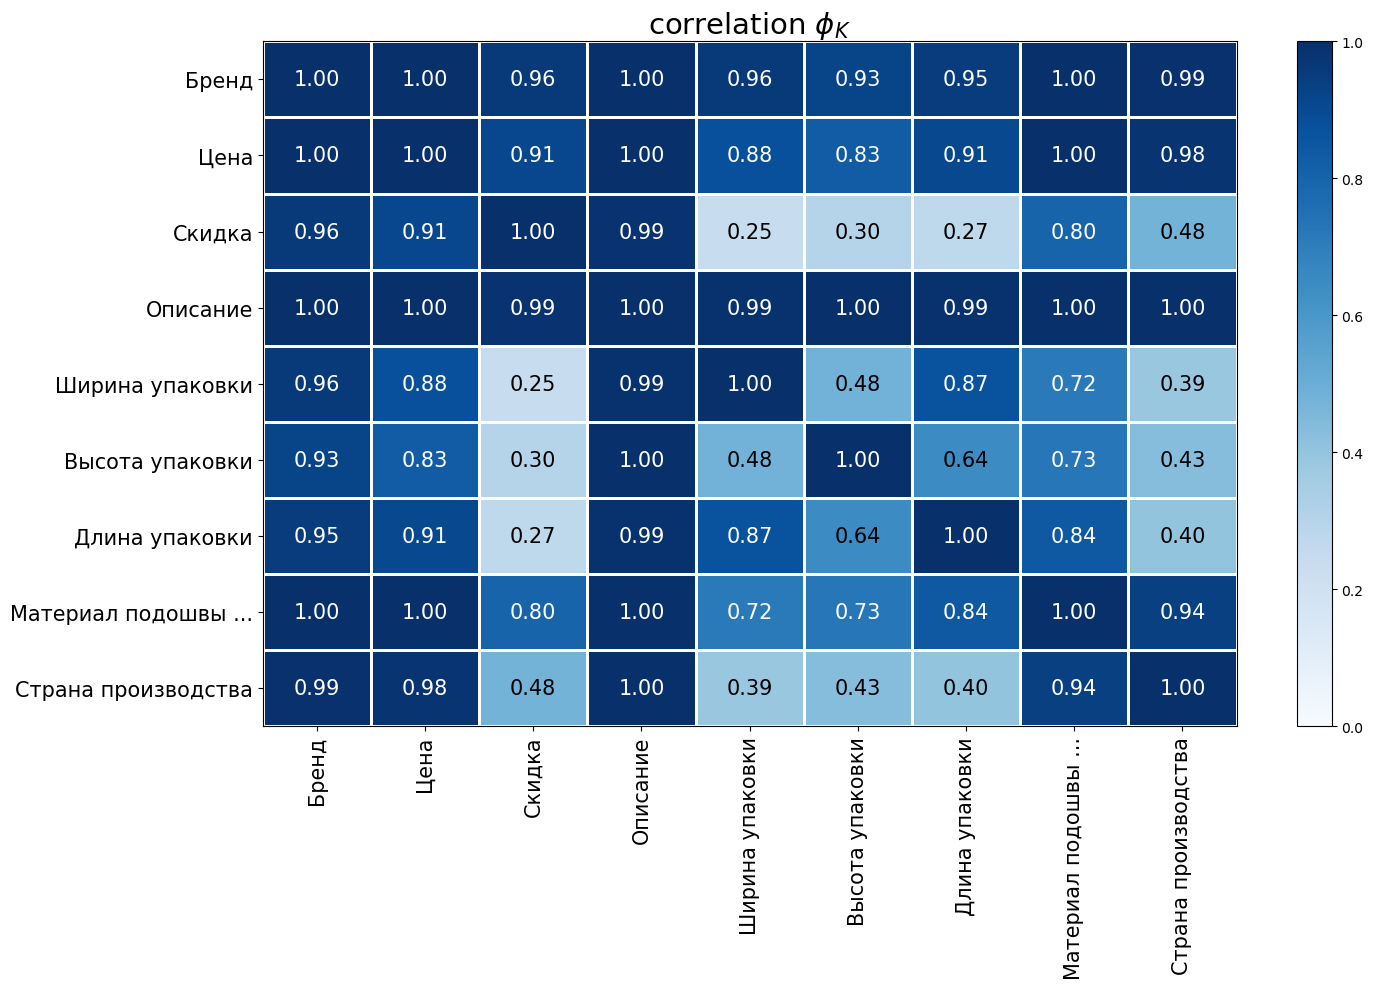

In [32]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(15, 10))
plt.tight_layout()

3.Model Training

In [37]:
from nltk.stem.porter import PorterStemmer

from string import punctuation


In [38]:
punctuation_symbols = []
for symbol in punctuation:
    punctuation_symbols.append((symbol, ''))

In [40]:
punctuation_symbols

[('!', ''),
 ('"', ''),
 ('#', ''),
 ('$', ''),
 ('%', ''),
 ('&', ''),
 ("'", ''),
 ('(', ''),
 (')', ''),
 ('*', ''),
 ('+', ''),
 (',', ''),
 ('-', ''),
 ('.', ''),
 ('/', ''),
 (':', ''),
 (';', ''),
 ('<', ''),
 ('=', ''),
 ('>', ''),
 ('?', ''),
 ('@', ''),
 ('[', ''),
 ('\\', ''),
 (']', ''),
 ('^', ''),
 ('_', ''),
 ('`', ''),
 ('{', ''),
 ('|', ''),
 ('}', ''),
 ('~', '')]

In [41]:
from sklearn import preprocessing,model_selection,linear_model
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import catboost as ctb

In [43]:
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '',punctuation))

In [35]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [50]:
reg = linear_model.LinearRegression()
ridge = linear_model.Ridge()
lasso = linear_model.Lasso()
en = linear_model.ElasticNet()
dtr = DecisionTreeRegressor()
xgb = XGBRegressor()
catb = ctb.CatBoostRegressor()

In [51]:
def create_global_train_test(global_df: pd.DataFrame)->pd.DataFrame:
    
    #Разделение данных на трейн и тест
    global_train,global_test = model_selection.train_test_split(global_df,test_size=0.2,random_state=42)
    
    return global_train,global_test

In [52]:
def create_X_y(global_train,target):
    #Разделяет глобальную трейн выборку на трейн и тест выборки
    X = global_train.drop([target],axis=1)
    
    y = global_train[target]
    
    return X,y

In [121]:
def pipeline(data: pd.DataFrame, categorical_features: list, numeric_features: list)-> pd.DataFrame:
    porter = PorterStemmer()

    #функция принимает данные и список категориальных колонок и преобразует их в числовые колнки
    oe = preprocessing.OrdinalEncoder()
    ss = preprocessing.RobustScaler()
    
    for feature in categorical_features:
        data[feature] = data[feature].replace(np.nan,'')
        data[feature] = data[feature].apply(porter.stem)

    df['Описание'] = df['Описание'].apply(remove_punctuation)
    df['Описание'] = df['Описание'].apply(to_lower)
    df['Описание'] = df['Описание'].apply(porter.stem)
        
        
    for feature in numeric_features:
        data[feature] = ss.fit_transform(np.array(data[feature]).reshape((-1, 1)))
        data[feature] = data[feature].replace(np.nan,data[feature].mean())
        
    return data

In [122]:
def baseline_model(test:pd.DataFrame):
    
    #подсчитывает скор для бейзлайн модели
    mape = mean_absolute_percentage_error
    dummy_target = [test.mean() for x in test]
    mape_baseline = rmse(np.array(test),np.array(dummy_target))
    
    print(f'Baseline MAPE: {mape_baseline}\n')

In [123]:
def get_basic_models_scores(model,X_train,y_train,X_test,y_test):
    
    #Возвращает значение MAPE для полученной модели
    mape = mean_absolute_percentage_error
    model.fit(X_train,y_train)
    y_pred = model.predict(X_train)
    print(rmse(y_pred,y_train))

In [173]:
df_filtered

,Страна производства,Материал подошвы обуви,Длина упаковки,Высота упаковки,Ширина упаковки,Описание,Скидка,Цена,Бренд
0,вьетнам,croslit,-3.25,-2.0,-1.666667,Сабо Bayaband Clog,0.233333,6499,croc
1,вьетнам,croslit,-3.25,-2.0,-1.666667,Стиль Crocband отличает высокая подошва обтека...,-0.400000,4699,croc
2,китай,тпр,0.00,0.0,0.000000,•\tСохраняй комфорт в кроссовках Nike Air Forc...,0.600000,14000,обувь
3,вьетнам,термоэластопласт,0.50,0.0,-0.166667,ОБРАЩАЕМ ВАШЕ ВНИМАНИЕ-КРОССОВКИ МАЛОМЕРЯТ НА ...,0.133333,9600,nike
4,китай,"пу (pu, полиуретан)",-0.25,-1.0,-0.333333,"Сандалии мужские для работы ""Аскет"" подойдут д...",-0.166667,2775,мистраль.
...,...,...,...,...,...,...,...,...,...
5314,индия,полиуретан,0.75,0.0,-0.166667,Мужские кеды из натуральной кожи ECCO STREET L...,-1.666667,11990,ecco
5315,nan,nan,-0.75,3.0,0.500000,Получите максимальную отдачу от каждого шага с...,-0.733333,16299,brook
5316,вьетнам,тпр,-0.25,0.0,-0.333333,Беговые кроссовки – это идеальное решение для ...,-0.400000,9999,asic
5317,nan,резина,-0.75,3.0,-0.333333,"ОБРАЩАЕМ ВАШЕ ВНИМЕНИЕ, эти КРОССОВКИ МАЛОМЕРЯ...",0.600000,13500,sigma


In [174]:
df_filtered = pipeline(df_filtered,CATEGORICAL_COLUMNS,NUMERIC_COLUMS)

In [60]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [61]:
df['Бренд'].isna().sum()

0

In [175]:
cv = CountVectorizer(min_df=10)
X_category_main = cv.fit_transform(df_filtered['Страна производства'])
X_category_sub1 = cv.fit_transform(df_filtered['Материал подошвы обуви'])

In [176]:
from collections import Counter

def reducecolumns(Col):
    # remove columns with <= 1% non-zero entries (arbitrary choice so that notebook doesn't crash)
    n_docs = Counter(Col.nonzero()[1])
    cols_to_keep = [k for k, v in n_docs.items() if v > .0005 * Col.shape[0]]
    return Col[:, cols_to_keep]

In [157]:

print("Category Main Shape: " + str(reducecolumns(X_category_main).shape))
print("Category Sub1 Shape: " + str(reducecolumns(X_category_sub1).shape))

Category Main Shape: (4255, 10)
Category Sub1 Shape: (4255, 74)


In [158]:
from scipy.sparse import csr_matrix, hstack

In [177]:
tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')
X_description = tv.fit_transform(df_filtered['Описание'])

In [178]:
X_description

<5319x55000 sparse matrix of type '<class 'numpy.float64'>'
	with 1337990 stored elements in Compressed Sparse Row format>

In [179]:
X_dummies = csr_matrix(pd.get_dummies(df_filtered[['Страна производства', 'Материал подошвы обуви']], sparse=True).values)

In [180]:
df_filtered

,Страна производства,Материал подошвы обуви,Длина упаковки,Высота упаковки,Ширина упаковки,Описание,Скидка,Цена,Бренд
0,вьетнам,croslit,-3.25,-2.0,-1.666667,Сабо Bayaband Clog,0.233333,6499,croc
1,вьетнам,croslit,-3.25,-2.0,-1.666667,Стиль Crocband отличает высокая подошва обтека...,-0.400000,4699,croc
2,китай,тпр,0.00,0.0,0.000000,•\tСохраняй комфорт в кроссовках Nike Air Forc...,0.600000,14000,обувь
3,вьетнам,термоэластопласт,0.50,0.0,-0.166667,ОБРАЩАЕМ ВАШЕ ВНИМАНИЕ-КРОССОВКИ МАЛОМЕРЯТ НА ...,0.133333,9600,nike
4,китай,"пу (pu, полиуретан)",-0.25,-1.0,-0.333333,"Сандалии мужские для работы ""Аскет"" подойдут д...",-0.166667,2775,мистраль.
...,...,...,...,...,...,...,...,...,...
5314,индия,полиуретан,0.75,0.0,-0.166667,Мужские кеды из натуральной кожи ECCO STREET L...,-1.666667,11990,ecco
5315,nan,nan,-0.75,3.0,0.500000,Получите максимальную отдачу от каждого шага с...,-0.733333,16299,brook
5316,вьетнам,тпр,-0.25,0.0,-0.333333,Беговые кроссовки – это идеальное решение для ...,-0.400000,9999,asic
5317,nan,резина,-0.75,3.0,-0.333333,"ОБРАЩАЕМ ВАШЕ ВНИМЕНИЕ, эти КРОССОВКИ МАЛОМЕРЯ...",0.600000,13500,sigma


In [182]:
sparse_merge = hstack((X_dummies,reducecolumns(X_description), reducecolumns(X_category_main), reducecolumns(X_category_sub1),df_filtered[NUMERIC_COLUMS])).tocsr()

print(sparse_merge.shape)

(5319, 55123)


In [201]:
print(sparse_merge[5318].toarray())

[[ 0.          0.          0.         ...  0.         -0.33333333
   0.2       ]]


In [185]:
TARGET

'Цена'

In [186]:
features_train, features_test, target_train, target_test = train_test_split(sparse_merge, df_filtered[TARGET], test_size = .35, random_state = 1)

In [188]:
get_basic_models_scores(reg,features_train,target_train,features_train,target_test)

851.3703766537033


In [189]:
get_basic_models_scores(ridge,features_train,target_train,features_train,target_test)

2160.704047672826


In [190]:
get_basic_models_scores(lasso,features_train,target_train,features_train,target_test)

2567.8509463867385


In [191]:
get_basic_models_scores(en,features_train,target_train,features_train,target_test)

5958.443586537885


In [192]:
get_basic_models_scores(xgb,features_train,target_train,features_train,target_test)

874.2316649937219


In [193]:
get_basic_models_scores(catb,features_train,target_train,features_train,target_test)

Learning rate set to 0.049807
0:	learn: 6511.2910665	total: 202ms	remaining: 3m 21s
1:	learn: 6406.4499744	total: 452ms	remaining: 3m 45s
2:	learn: 6296.9616491	total: 693ms	remaining: 3m 50s
3:	learn: 6198.0987432	total: 933ms	remaining: 3m 52s
4:	learn: 6105.6322484	total: 1.19s	remaining: 3m 56s
5:	learn: 6006.6201863	total: 1.42s	remaining: 3m 55s
6:	learn: 5898.1811722	total: 1.68s	remaining: 3m 58s
7:	learn: 5820.8389488	total: 1.92s	remaining: 3m 57s
8:	learn: 5737.6232316	total: 2.15s	remaining: 3m 57s
9:	learn: 5655.6847668	total: 2.4s	remaining: 3m 57s
10:	learn: 5590.6111840	total: 2.64s	remaining: 3m 57s
11:	learn: 5513.9715221	total: 2.88s	remaining: 3m 57s
12:	learn: 5439.7304268	total: 3.13s	remaining: 3m 57s
13:	learn: 5365.5132872	total: 3.36s	remaining: 3m 56s
14:	learn: 5307.7106718	total: 3.61s	remaining: 3m 56s
15:	learn: 5226.2066996	total: 3.85s	remaining: 3m 56s
16:	learn: 5159.9432276	total: 4.08s	remaining: 3m 56s
17:	learn: 5107.0287355	total: 4.3s	remaining: